# Lecture 3a MCMC

# Introduction

In this notebook we will discuss the following algorithms n:
- **Markov chain**
  - Random walk
  - Discrete Markov chain
- **MCMC**
  - Metropolis–Hastings (MH): 1D binomial distribution
  - Bayesian coin-flip inference with MCMC (NUTS vs Random-Walk MH)

In [11]:
!pip install numpyro
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, Predictive

import arviz as az
from scipy.stats import norm, gamma, poisson, binom, beta as beta_dist


## Markov chain

#### Example
Let’s make a simulation of a chain with two different starting points: one chain starting at 50 and another at -27. The step to x(t+1) from x(t) is governed by a random number drawn from a normalized Gaussian PDF that is dependent on x(t):

$x_{t+1} = 0.9 x_t + v(t), \; v(t) \sim \mathcal{N}(0, 0.19)$.

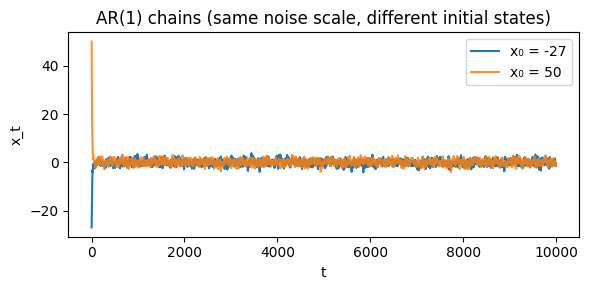

Var post-burn-in: 1.0395459935311053


In [12]:
# AR(1) Markov chain example
N = 10_000
sigma_v = np.sqrt(0.19)


import numpy as np
import matplotlib.pyplot as plt

# Optional: reproducibility
# np.random.seed(0)

# Assume these are already defined somewhere above:
# N = ...
# sigma_v = ...

# --- Chain 1 (x0 = -27) ---
x1 = np.empty(N)
x1[0] = -27.0
for j in range(1, N):
    eps = np.random.normal(0.0, sigma_v)
    x1[j] = 0.9 * x1[j-1] + eps

# --- Chain 2 (x0 = 50) ---
x2 = np.empty(N)
x2[0] = 50.0
for j in range(1, N):
    eps = np.random.normal(0.0, sigma_v)
    x2[j] = 0.9 * x2[j-1] + eps

# --- Plot both on the same graph ---
plt.figure(figsize=(6, 3))
plt.plot(x1, label="x₀ = -27", linewidth=1.5)
plt.plot(x2, label="x₀ = 50", linewidth=1.5, alpha=0.85)

plt.xlabel("t")
plt.ylabel("x_t")
plt.title("AR(1) chains (same noise scale, different initial states)")
plt.legend()
plt.tight_layout()
plt.show()

print("Var post-burn-in:", np.var(x1[1000:]))

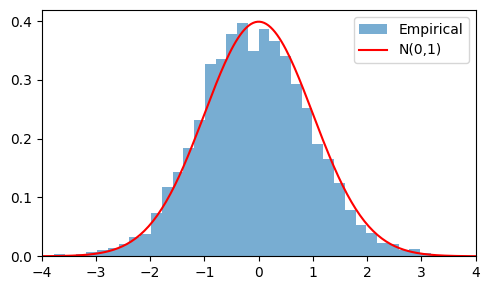

In [13]:
# Histogram vs N(0,1)
plt.figure(figsize=(5,3))
samples = x1[1000:]
plt.hist(samples, bins=40, density=True, alpha=0.6, label="Empirical")

z = np.linspace(-4, 4, 200)
plt.plot(z, norm.pdf(z, 0, 1), 'r', label="N(0,1)")
plt.xlim(-4, 4)
plt.legend()
plt.tight_layout()
plt.show()


#### Example
Finite-state Markov chain and powers of the transition matrix.

In [14]:
T = np.array([
    [0.0, 0.5, 0.0, 0.0, 0.5],
    [0.5, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.5, 0.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 0.0, 0.5],
    [0.5, 0.0, 0.0, 0.5, 0.0],
])

T2 = T @ T
print("P(X_{t+2}=3 | X_t=1):", T2[0, 2])
print("T^2:", T2)
T30 = np.linalg.matrix_power(T, 30)
print("T^30:", T30)


P(X_{t+2}=3 | X_t=1): 0.25
T^2: [[0.5  0.   0.25 0.25 0.  ]
 [0.   0.5  0.   0.25 0.25]
 [0.25 0.   0.5  0.   0.25]
 [0.25 0.25 0.   0.5  0.  ]
 [0.   0.25 0.25 0.   0.5 ]]
T^30: [[0.20069309 0.19943928 0.20021418 0.20021418 0.19943928]
 [0.19943928 0.20069309 0.19943928 0.20021418 0.20021418]
 [0.20021418 0.19943928 0.20069309 0.19943928 0.20021418]
 [0.20021418 0.20021418 0.19943928 0.20069309 0.19943928]
 [0.19943928 0.20021418 0.20021418 0.19943928 0.20069309]]


#### Example
Sampling from a discrete Markov chain (analog of `mc_sample_path`).

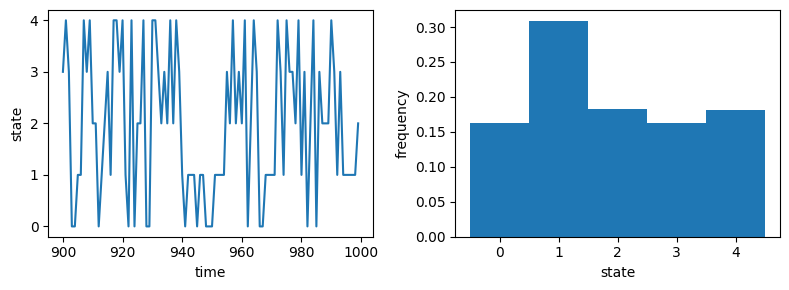

In [15]:
def mc_sample_path(P, init=0, sample_size=1000, rng=None):
    """Sample path from discrete Markov chain with transition matrix P."""
    if rng is None:
        rng = np.random.default_rng()
    n = P.shape[0]
    assert P.shape == (n, n)
    dists = [np.cumsum(P[i]) for i in range(n)]
    X = np.empty(sample_size, dtype=int)
    X[0] = init
    for t in range(1, sample_size):
        u = rng.uniform()
        cdf = dists[X[t-1]]
        X[t] = np.searchsorted(cdf, u)
    return X

P1 = np.array([
    [0.35, 0.35, 0.10, 0.10, 0.10],
    [0.15, 0.55, 0.10, 0.10, 0.10],
    [0.15, 0.15, 0.10, 0.20, 0.40],
    [0.15, 0.15, 0.40, 0.10, 0.20],
    [0.15, 0.15, 0.20, 0.40, 0.10],
])

x_path = mc_sample_path(P1, init=0, sample_size=1000)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
ax1.plot(range(900,1000), x_path[900:1000])
ax1.set_xlabel("time")
ax1.set_ylabel("state")

ax2.hist(x_path[100:1000], bins=np.arange(6)-0.5, density=True)
ax2.set_xlabel("state")
ax2.set_ylabel("frequency")
plt.tight_layout()
plt.show()


## 3) Metropolis–Hastings (MH)

### 3.1 The core idea
Given a target density $(\pi(x)$) (up to a constant), define a proposal distribution $(q(x'\mid x))$.

Algorithm at state \(x\):
1. Propose $(x'\sim q(\cdot\mid x))$
2. Accept with probability
$
\alpha(x, x') = \min\Bigl(1,\ \frac{\pi(x')\,q(x\mid x')}{\pi(x)\,q(x'\mid x)}\Bigr).
$
3. If accepted set $(x\leftarrow x')$, else stay at \(x\).

### 3.2 Why this works (one‑line proof sketch)
MH is built so that the transition kernel satisfies **detailed balance** with \(\pi\), hence \(\pi\) is stationary.

### 3.3 Special case: Random‑Walk Metropolis
Use $(x' = x + \epsilon)$, with $(\epsilon\sim \mathcal{N}(0,\sigma^2 I))$.
Then $(q(x'\mid x)=q(x\mid x'))$ (symmetric) and
$
\alpha = \min(1,\ \pi(x')/\pi(x)).
$

### 3.4 Practical tuning
- If $\sigma$ too small → high acceptance but slow exploration (high autocorrelation).
- If $\sigma$ too large → many rejections.

> Rule of thumb (high‑dim random walk): acceptance ~ 0.23 is often near‑optimal.

---

### 3.5 Simple example: sample a 1D bimodal target
Target:
$
\pi(x) = 0.5\,\mathcal{N}(-3,1) + 0.5\,\mathcal{N}(+3,1)
$
This is a classic case where random‑walk MH may have trouble jumping between modes.

We’ll:
- Implement MH from scratch.
- Visualize trace, histogram, acceptance, and autocorrelation.


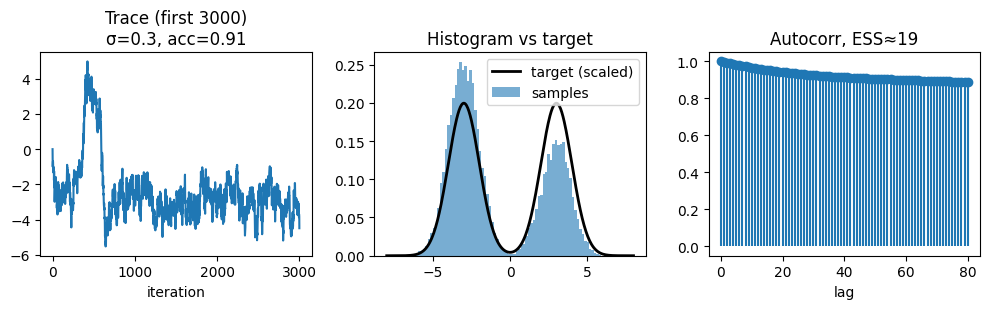

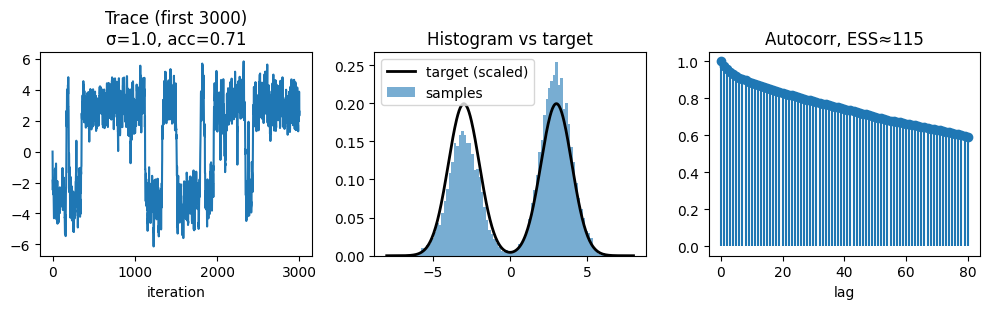

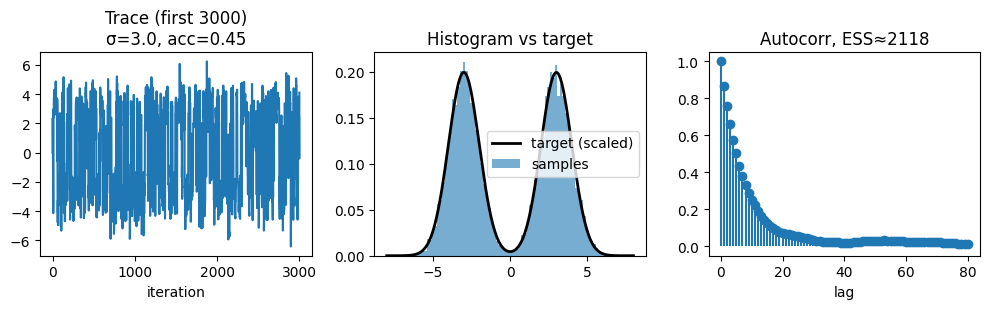

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
import numpyro
import numpyro.diagnostics as diag

def logsumexp(a, b):
    m = max(a, b)
    return m + np.log(np.exp(a-m) + np.exp(b-m))

def log_target_bimodal(x):
    a = -0.5*(x+3)**2
    b = -0.5*(x-3)**2
    return logsumexp(a, b)

def rw_metropolis(logpi, x0, n, sigma):
    x = np.zeros(n)
    x[0] = x0
    acc = 0
    lp = logpi(x0)
    for t in range(1, n):
        prop = x[t-1] + np.random.normal(0, sigma)
        lp_prop = logpi(prop)
        if np.log(np.random.rand()) < (lp_prop - lp):
            x[t] = prop
            lp = lp_prop
            acc += 1
        else:
            x[t] = x[t-1]
    return x, acc/(n-1)

# Define autocorr function (adapted from acf_1d in cell bTxKV4EDT0Ts)
def autocorr(x, max_lag):
    x = np.asarray(x)
    x = x - x.mean()
    var = np.dot(x, x) / x.size
    acf = [1.0]
    for lag in range(1, max_lag + 1):
        acf.append(np.dot(x[:-lag], x[lag:]) / ((x.size - lag) * var + 1e-15))
    return np.array(acf)

# Define ess using numpyro.diagnostics
def ess(samples):
    # Reshape samples to (num_chains, num_samples) as numpyro.diagnostics expects
    return diag.effective_sample_size(samples.reshape(1, -1))

n = 40_000
for sigma in [0.3, 1.0, 3.0]:
    chain, ar = rw_metropolis(log_target_bimodal, x0=0.0, n=n, sigma=sigma)
    burn = 2_000
    samples = chain[burn:]

    plt.figure(figsize=(10,3.2))
    plt.subplot(1,3,1)
    plt.plot(chain[:3000])
    plt.title(f"Trace (first 3000)\nσ={sigma}, acc={ar:.2f}")
    plt.xlabel("iteration")

    plt.subplot(1,3,2)
    xs = np.linspace(-8, 8, 400)
    targ = np.exp([log_target_bimodal(x) for x in xs])
    # Use np.trapezoid instead of np.trapz to address DeprecationWarning
    targ = targ / np.trapezoid(targ, xs)
    plt.plot(xs, targ, 'k-', lw=2, label='target (scaled)')
    plt.hist(samples, bins=80, density=True, alpha=0.6, label='samples')
    plt.title("Histogram vs target")
    plt.legend()

    plt.subplot(1,3,3)
    ac = autocorr(samples, max_lag=80)
    plt.stem(range(len(ac)), ac, basefmt=" ")
    plt.title(f"Autocorr, ESS≈{ess(samples):.0f}")
    plt.xlabel("lag")

    plt.tight_layout()
    plt.show()

## Bayesian coin-flip inference with MCMC (NUTS vs Random-Walk MH)

**Goal.** We observe **k heads out of n flips** and infer the unknown coin bias **θ ∈ (0,1)** using Bayesian inference.

**Model.**
- Prior:  θ ~ Beta(α, β)
- Likelihood: k | θ ~ Binomial(n, θ)

Because Beta is conjugate to Binomial, the posterior is known in closed form:
- Posterior:  θ | k,n ~ Beta(a_post, b_post)
- where a_post = α + k and b_post = β + (n − k)

**Why run MCMC if the posterior is analytic?**
1) To **validate** samplers against a known ground-truth posterior.
2) To **compare efficiency** of a modern gradient-based sampler (NUTS) vs a basic random-walk MH method.
3) To practice **diagnostics**: ESS, R-hat, and autocorrelation.

**What the code will do.**
1) Run **NUTS (NumPyro)** on the Beta–Binomial model and collect θ samples from 4 chains.
2) Run **Random-Walk Metropolis–Hastings (RW-MH)** on the **logit scale** φ = logit(θ), using Gaussian proposals in φ and transforming back to θ.
3) Compute diagnostics (ESS, R-hat, ACF) for both methods.
4) Plot sampled histograms overlaid with:
   - the **analytical posterior** Beta(a_post, b_post)
   - the **prior** Beta(α, β)


/tmp/ipython-input-3931794855.py:35: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_nuts = MCMC(nuts_kernel, num_warmup=num_warmup_nuts, num_samples=num_samples_nuts,



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.88      0.03      0.88      0.83      0.93   3449.04      1.00

Number of divergences: 0
MH acceptance rates per chain: [0.702 0.696 0.702 0.694]

=== Rubin decomposition (NUTS) ===
W: 0.000977
B: 0.002822
var_hat_plus: 0.000978
Rhat: 1.000378

=== Rubin decomposition (MH) ===
W: 0.000908
B: 0.009038
var_hat_plus: 0.000911
Rhat: 1.001790


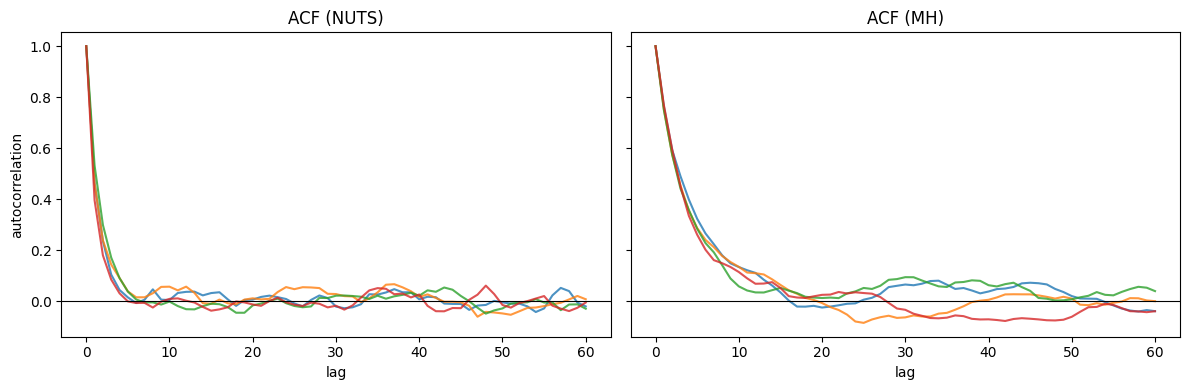

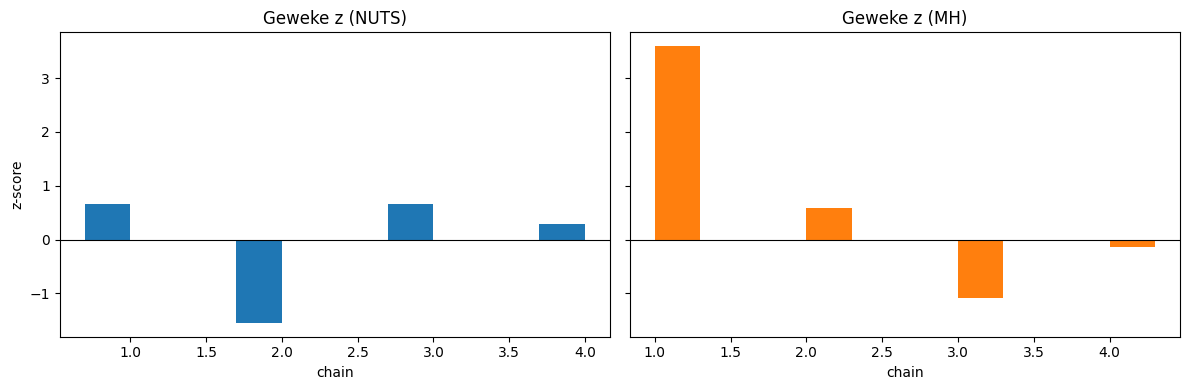

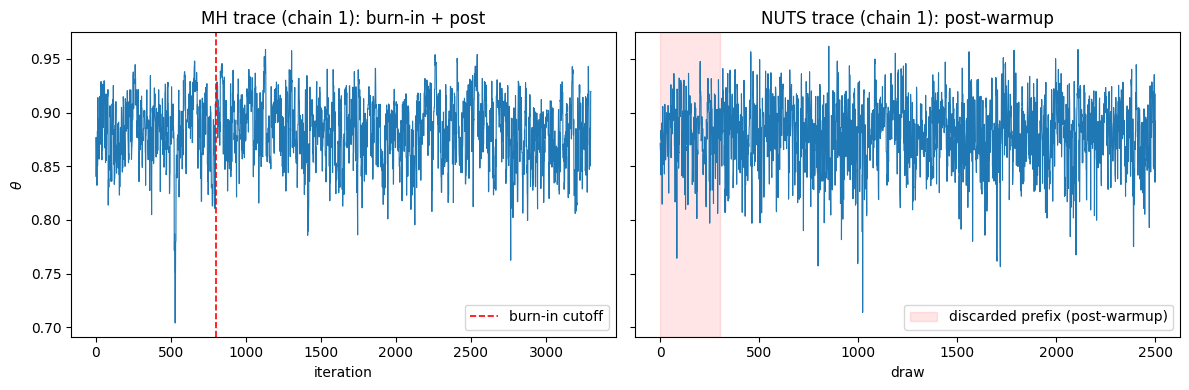

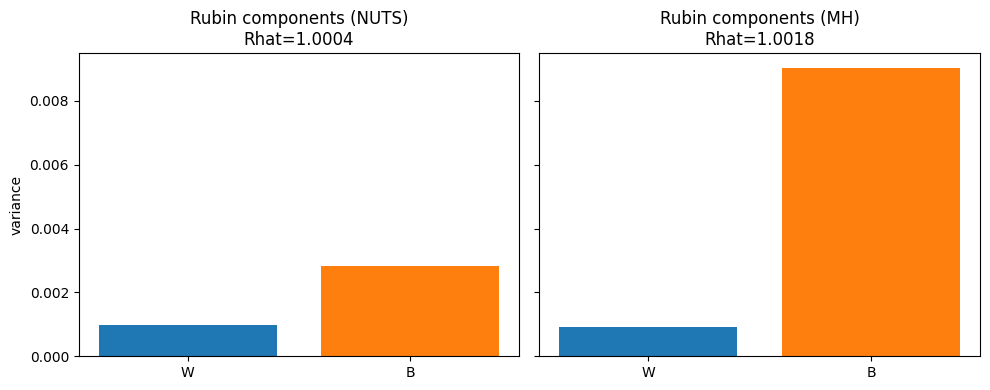

In [20]:
# %% Imports
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import diagnostics as diag

import matplotlib.pyplot as plt
from scipy.special import betaln  # log Beta function

# ---------- Problem settings ----------
k = 90
n = 100
alpha = 5.0
beta  = 3.0

a_post = k + alpha
b_post = (n - k) + beta

# ---------- Model ----------
def coin_model(k=None, n=None, alpha=1.0, beta=1.0):
    theta = numpyro.sample("theta", dist.Beta(alpha, beta))
    numpyro.sample("k", dist.Binomial(total_count=n, probs=theta), obs=k)

# ---------- NUTS sampling ----------
rng_key = random.PRNGKey(0)
num_warmup_nuts = 800
num_samples_nuts = 2500
num_chains = 4

nuts_kernel = NUTS(coin_model)
mcmc_nuts = MCMC(nuts_kernel, num_warmup=num_warmup_nuts, num_samples=num_samples_nuts,
                 num_chains=num_chains, progress_bar=False)
mcmc_nuts.run(rng_key, k=k, n=n, alpha=alpha, beta=beta)
mcmc_nuts.print_summary()
nuts_theta = mcmc_nuts.get_samples(group_by_chain=True)["theta"]  # shape (C, S)

# ---------- MH baseline on logit scale ----------
def logit(p):     return np.log(p) - np.log(1.0 - p)
def inv_logit(z): return 1.0 / (1.0 + np.exp(-z))

def log_target_phi(phi, a_post, b_post):
    # Posterior on phi=logit(theta) up to a constant (Jacobian included):
    # log pi(phi) = a_post*log(theta) + b_post*log(1-theta)
    th = inv_logit(phi)
    if th <= 0.0 or th >= 1.0:
        return -np.inf
    return a_post*np.log(th) + b_post*np.log(1.0 - th)

def rw_mh_logit_full(a_post, b_post, num_samples=2500, num_warmup=800, step=0.35, seed=123):
    """
    Random-walk MH on phi=logit(theta). Returns full trace including warmup.
    """
    rng = np.random.RandomState(seed)
    theta0 = a_post / (a_post + b_post)
    phi = logit(theta0)
    logp = log_target_phi(phi, a_post, b_post)

    total = num_warmup + num_samples
    trace_phi = np.empty(total)
    accept = 0
    for t in range(total):
        prop = phi + rng.normal(scale=step)
        logp_prop = log_target_phi(prop, a_post, b_post)
        if np.log(rng.rand()) < (logp_prop - logp):
            phi, logp = prop, logp_prop
            if t >= num_warmup:
                accept += 1
        trace_phi[t] = phi
    acc_rate = accept / max(1, num_samples)
    return inv_logit(trace_phi), acc_rate

mh_traces, mh_acc_rates = [], []
for c in range(num_chains):
    tr, acc = rw_mh_logit_full(a_post, b_post,
                               num_samples=num_samples_nuts,
                               num_warmup=num_warmup_nuts,
                               step=0.30, seed=123+c)
    mh_traces.append(tr)     # full trace (warmup + post)
    mh_acc_rates.append(acc)

mh_trace_full = np.stack(mh_traces, axis=0)  # (C, W+S)
mh_theta      = mh_trace_full[:, num_warmup_nuts:]  # post-warmup (C, S)
print("MH acceptance rates per chain:", np.round(mh_acc_rates, 3))

# ---------- Utilities: ACF, HAC variance (Newey–West), Geweke, Rubin W/B ----------
def acf_1d(x, max_lag=60):
    x = np.asarray(x)
    x = x - x.mean()
    var = np.dot(x, x) / x.size
    acf = [1.0]
    for lag in range(1, max_lag+1):
        acf.append(np.dot(x[:-lag], x[lag:]) / ((x.size - lag) * var + 1e-15))
    return np.array(acf)

def hac_variance(x, max_lag=None):
    """
    Newey–West (Bartlett) estimator of variance of the sample mean accounting for autocorrelation.
    Returns var(mean(x)).
    """
    x = np.asarray(x)
    N = x.size
    x_c = x - x.mean()
    gamma0 = np.dot(x_c, x_c) / N
    if max_lag is None:
        # A common rule: floor(N**(1/3))
        max_lag = int(np.floor(N ** (1/3)))
        max_lag = max(1, max_lag)
    # Autocovariances
    acov = []
    for h in range(1, max_lag+1):
        acov.append(np.dot(x_c[:-h], x_c[h:]) / (N - h))
    acov = np.array(acov)
    # Bartlett weights
    w = 1.0 - np.arange(1, max_lag+1) / (max_lag + 1.0)
    s_hat = gamma0 + 2.0 * np.sum(w * acov)
    return s_hat / N  # variance of mean

def geweke_z(chain, first_frac=0.1, last_frac=0.5, max_lag=None):
    """
    Geweke diagnostic z-score for a single chain.
    Compares mean of first_frac and last_frac segments using HAC variances.
    """
    x = np.asarray(chain)
    N = x.size
    nA = max(3, int(np.floor(first_frac * N)))
    nB = max(3, int(np.floor(last_frac * N)))
    A = x[:nA]
    B = x[N - nB:]
    mA, mB = A.mean(), B.mean()
    vA = hac_variance(A, max_lag=max_lag)
    vB = hac_variance(B, max_lag=max_lag)
    # Difference of means normalized by combined variance
    denom = np.sqrt(vA + vB)
    if denom == 0:
        return np.nan
    return (mA - mB) / denom

def rubin_wb_rhat(samples_by_chain):
    """
    Compute Rubin's within W, between B, var_hat_plus, and Rhat for chains x draws array.
    """
    samples_by_chain = np.asarray(samples_by_chain)
    C, S = samples_by_chain.shape
    chain_means = samples_by_chain.mean(axis=1)             # (C,)
    chain_vars  = samples_by_chain.var(axis=1, ddof=1)      # (C,)
    m_dot = chain_means.mean()                               # grand mean
    # Between-chain
    B = (S / (C - 1)) * np.sum((chain_means - m_dot)**2)
    # Within-chain
    W = chain_vars.mean()
    # Marginal posterior variance estimate
    var_hat_plus = ((S - 1) / S) * W + (1 / S) * B
    Rhat = np.sqrt(var_hat_plus / W)
    return dict(W=W, B=B, var_hat_plus=var_hat_plus, Rhat=float(Rhat))

# ---------- Compute diagnostics ----------
max_lag = 60
# ACF arrays (C, L+1)
acf_nuts = np.stack([acf_1d(nuts_theta[c], max_lag=max_lag) for c in range(num_chains)], axis=0)
acf_mh   = np.stack([acf_1d(mh_theta[c],   max_lag=max_lag) for c in range(num_chains)], axis=0)

# Geweke z per chain
geweke_nuts = np.array([geweke_z(nuts_theta[c], first_frac=0.1, last_frac=0.5) for c in range(num_chains)])
geweke_mh   = np.array([geweke_z(mh_theta[c],   first_frac=0.1, last_frac=0.5) for c in range(num_chains)])

# Rubin decomposition
rubin_nuts = rubin_wb_rhat(nuts_theta)
rubin_mh   = rubin_wb_rhat(mh_theta)

print("\n=== Rubin decomposition (NUTS) ===")
for k,v in rubin_nuts.items(): print(f"{k}: {v:.6f}")
print("\n=== Rubin decomposition (MH) ===")
for k,v in rubin_mh.items(): print(f"{k}: {v:.6f}")

# ---------- Plots ----------
# 1) ACF plots
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for c in range(num_chains):
    ax[0].plot(np.arange(max_lag+1), acf_nuts[c], alpha=0.8, label=f'Chain {c+1}' if c==0 else None)
ax[0].axhline(0, color='k', lw=0.8)
ax[0].set_title('ACF (NUTS)'); ax[0].set_xlabel('lag'); ax[0].set_ylabel('autocorrelation')

for c in range(num_chains):
    ax[1].plot(np.arange(max_lag+1), acf_mh[c], alpha=0.8, label=f'Chain {c+1}' if c==0 else None, color=f'C{c}')
ax[1].axhline(0, color='k', lw=0.8)
ax[1].set_title('ACF (MH)'); ax[1].set_xlabel('lag')
plt.tight_layout()
plt.show()

# 2) Geweke z-scores
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].axhline(0, color='k', lw=0.8)
ax[0].bar(np.arange(num_chains)+1 - 0.15, geweke_nuts, width=0.3, color='C0')
ax[0].set_title('Geweke z (NUTS)'); ax[0].set_xlabel('chain'); ax[0].set_ylabel('z-score')

ax[1].axhline(0, color='k', lw=0.8)
ax[1].bar(np.arange(num_chains)+1 + 0.15, geweke_mh, width=0.3, color='C1')
ax[1].set_title('Geweke z (MH)'); ax[1].set_xlabel('chain')
plt.tight_layout()
plt.show()

# 3) Burn-in visualization (trace)
#    For MH: we stored full traces; for NUTS, NumPyro discards warmup by default.
#    We'll show MH full trace with a vertical line at warmup, and for NUTS we mark an initial "discarded prefix"
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
# MH: full trace of chain 1
ax[0].plot(mh_trace_full[0], lw=0.8)
ax[0].axvline(num_warmup_nuts, color='r', ls='--', lw=1.2, label='burn-in cutoff')
ax[0].set_title('MH trace (chain 1): burn-in + post')
ax[0].set_xlabel('iteration'); ax[0].set_ylabel(r'$\theta$'); ax[0].legend()

# NUTS: post-warmup trace only (we mark the first 300 draws as "discarded prefix" for visualization)
prefix = 300
ax[1].plot(nuts_theta[0], lw=0.8)
ax[1].axvspan(0, prefix, color='r', alpha=0.1, label='discarded prefix (post-warmup)')
ax[1].set_title('NUTS trace (chain 1): post-warmup')
ax[1].set_xlabel('draw'); ax[1].legend()
plt.tight_layout()
plt.show()

# 4) Rubin W and B bars
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
ax[0].bar(['W','B'], [rubin_nuts['W'], rubin_nuts['B']], color=['C0','C1'])
ax[0].set_title(f'Rubin components (NUTS)\nRhat={rubin_nuts["Rhat"]:.4f}')
ax[0].set_ylabel('variance')

ax[1].bar(['W','B'], [rubin_mh['W'], rubin_mh['B']], color=['C0','C1'])
ax[1].set_title(f'Rubin components (MH)\nRhat={rubin_mh["Rhat"]:.4f}')
plt.tight_layout()
plt.show()


## Discussion of results

### 1) Do the samples match the analytical posterior?

Check the histograms vs the red analytical curve Beta(a_post, b_post).
- If the samplers are correct, both NUTS and RW-MH histograms should align closely with the analytical posterior.
- The posterior should be more concentrated than the prior (dashed curve), reflecting information from the data.

### 2) NUTS vs RW-MH: mixing and efficiency

Even if both samplers are correct, they may differ in efficiency:
- **NUTS** usually mixes faster (lower autocorrelation) and achieves higher **effective sample size (ESS)** per draw.
- **RW-MH** often mixes more slowly because random-walk proposals explore locally; efficiency depends strongly on the proposal step size.

### 3) RW-MH acceptance rate interpretation

Use the printed acceptance rates to tune the MH step size:
- Very low acceptance → step too large → reduce `step`
- Very high acceptance → step too small → increase `step` (chain moves slowly)

A good step size balances movement (exploration) with a reasonable acceptance rate.

### 4) Convergence diagnostics: ESS, R-hat, ACF

Interpret the diagnostics as follows:
- **R-hat ≈ 1.00** indicates chains are consistent (good convergence).
- **ESS** indicates how many “independent-equivalent” samples you effectively have; higher is better.



## Acknowledgements/ Document preparation
This code was developed with assistance from ChatGPT (OpenAI) and CoPilot (Microsoft). The instructor modified the text and code and verified the final results and wording.